# Homework 8.5

Section 8.5

Math 404

Winter 2020

Logan Schelly

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Exercise 8.23
Download the hourly report of Utah air quality (PM2.5 levels) for 2015 at http://www.airmonitoring.utah.gov/dataarchive/2015-PM2.5.csv.  We will focus on the north Provo data (station NP).  Values reported are micrograms per cubic meter.

In [2]:
aq = pd.read_csv("hw85_data.csv", skiprows=[1,2], index_col=0)['NP']
aq.index = pd.to_datetime(aq.index)
aq.to_frame().head(5)

NP
2015-01-01 00:00:00  19.2
2015-01-01 01:00:00  21.7
2015-01-01 02:00:00  19.3
2015-01-01 03:00:00  15.1
2015-01-01 04:00:00  12.8

## Part (i)
Clean up the data: Amoung other things, there should be no negative values.  Why not?  What is a good strategy for imputing the missing values?

In [3]:
#No negative values, because you can't have negative amounts of PM2.5 in the air.
aq[aq < 0] = 0

#Look at missing values.
missing = aq.isna()
missing.sum()

248

In [4]:
#Look at adjacent places.
missing = np.nonzero(missing.to_numpy())[0]
before = missing-1
after = missing+1
together = np.hstack([missing, before, after])
together = np.unique(together)
#print(together)

In [5]:
aq.iloc[together]

2015-01-29 12:00:00    13.8
2015-01-29 13:00:00     NaN
2015-01-29 14:00:00     6.4
2015-03-23 04:00:00     3.5
2015-03-23 05:00:00     NaN
2015-03-23 06:00:00     NaN
2015-03-23 07:00:00     6.6
2015-03-27 06:00:00     5.3
2015-03-27 07:00:00     NaN
2015-03-27 08:00:00     NaN
2015-03-27 09:00:00     9.2
2015-05-19 08:00:00     5.7
2015-05-19 09:00:00     NaN
2015-05-19 10:00:00     NaN
2015-05-19 11:00:00     NaN
2015-05-19 12:00:00     NaN
2015-05-19 13:00:00     3.0
2015-08-12 11:00:00     0.0
2015-08-12 12:00:00     NaN
2015-08-12 13:00:00     NaN
2015-08-12 14:00:00     NaN
2015-08-12 15:00:00     4.8
2015-08-25 09:00:00    17.5
2015-08-25 10:00:00     NaN
2015-08-25 11:00:00     NaN
2015-08-25 12:00:00     NaN
2015-08-25 13:00:00     4.8
2015-10-20 11:00:00     3.0
2015-10-20 12:00:00     NaN
2015-10-20 13:00:00     NaN
                       ... 
2015-10-29 14:00:00     NaN
2015-10-29 15:00:00     NaN
2015-10-29 16:00:00     NaN
2015-10-29 17:00:00     NaN
2015-10-29 18:00:00 

In [6]:
#One strategy would be to do a linear intperpolation from the nearest present values.
interpolated = aq.interpolate(method='time')
interpolated.iloc[together]

2015-01-29 12:00:00    13.800000
2015-01-29 13:00:00    10.100000
2015-01-29 14:00:00     6.400000
2015-03-23 04:00:00     3.500000
2015-03-23 05:00:00     4.533333
2015-03-23 06:00:00     5.566667
2015-03-23 07:00:00     6.600000
2015-03-27 06:00:00     5.300000
2015-03-27 07:00:00     6.600000
2015-03-27 08:00:00     7.900000
2015-03-27 09:00:00     9.200000
2015-05-19 08:00:00     5.700000
2015-05-19 09:00:00     5.160000
2015-05-19 10:00:00     4.620000
2015-05-19 11:00:00     4.080000
2015-05-19 12:00:00     3.540000
2015-05-19 13:00:00     3.000000
2015-08-12 11:00:00     0.000000
2015-08-12 12:00:00     1.200000
2015-08-12 13:00:00     2.400000
2015-08-12 14:00:00     3.600000
2015-08-12 15:00:00     4.800000
2015-08-25 09:00:00    17.500000
2015-08-25 10:00:00    14.325000
2015-08-25 11:00:00    11.150000
2015-08-25 12:00:00     7.975000
2015-08-25 13:00:00     4.800000
2015-10-20 11:00:00     3.000000
2015-10-20 12:00:00     3.006278
2015-10-20 13:00:00     3.012556
          

In [7]:
#However, that seems to create a problem with October 20th through October 29th.
#At this point, it seems like it would be easiest to just construct the model with the data that's present, and then
#Use the model to interpolate the missing data.

## Part (ii)
Construct a classical decomposition of the time series as follows:
### a
Estimate the trend with a symmetric length-24 moving average $\hat{T}_t^{24}$ corresponding to averaging over all the hours in a day and plot $\hat{T}_t$.

In [8]:
#aqdf = aq.to_frame()
N = aq.size
T_hat = pd.Series(np.empty(N), index=aq.index)

In [9]:
#Warning: this cell takes a bit to run.
for t in aq.index:
    
    #Constuct the windows for the symmetric moving average.
    twelve_hours = pd.to_timedelta('12 hours')
    start = t - twelve_hours
    end = t + twelve_hours
    
    #Use two windows, one biased forward by 1 hour, and other back by 1 hour
    window1 = pd.date_range(start=start, end=end, closed='left')
    window2 = pd.date_range(start=start, end=end, closed='right')
    
    #Average the backward-shifted times
    mean1 = aq[window1].mean(skipna=True)
    mean2 = aq[window2].mean(skipna=True)
    
    #average those two means to get T_hat for that time.
    T_hat[t] = (mean1 + mean2)/2

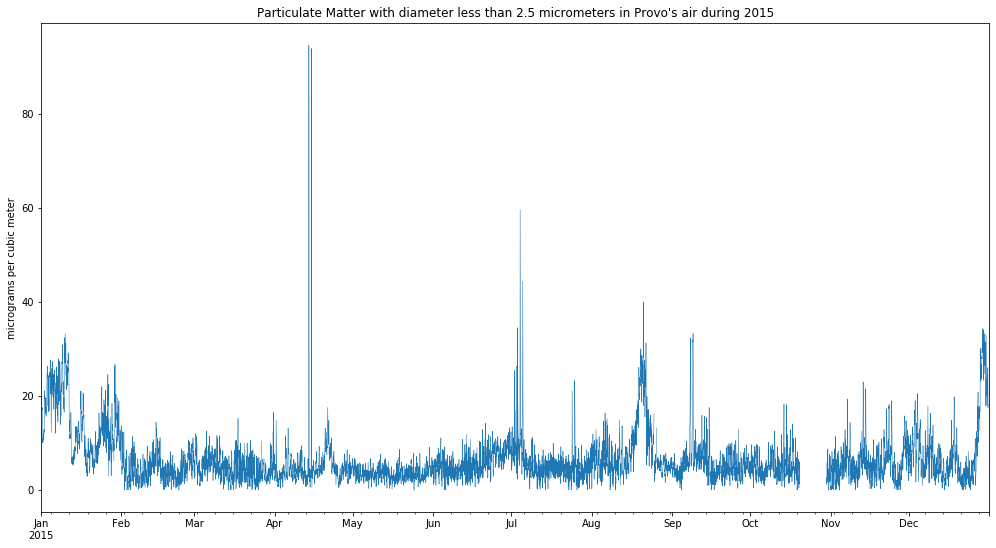

In [10]:
fig = plt.figure(figsize=(17, 9))
T_hat.plot(figure=fig, linewidth=.5)
plt.ylabel(r"micrograms per cubic meter")
plt.title("Particulate Matter with diameter less than 2.5 micrometers in Provo's air during 2015")
plt.show()

### b
Detrend the original series to $y_t = z_t - \hat{T}_t$ (drop a day on each end where $\hat{T}_t$ is not defined.)

In [11]:
y = aq - T_hat
#Drop the ending days
too_early = y.index < pd.to_datetime("1 January 2015 11:59")
too_late = y.index > pd.to_datetime("31 December 2015 00:00")
y = y[(~too_early)&(~too_late)]

### c
Compute the hour-of-the-day seasonal component by finding the mean of $y_t$ for each hour of the day -- that is, find
$$
\hat{S}_k = \text{mean}(y_k, y_{k+24}, y_{k+48}, \ldots)
$$
for each $k \in \{0, \ldots, 23\}$.

In [12]:
ydf = y.to_frame()
ydf.columns = ['y']
ydf['hour'] = ydf.index.hour
g = ydf.groupby('hour')
S = g.mean()
S.columns=['S']

### d
Plot the series $\hat{S}$.  Interpret.

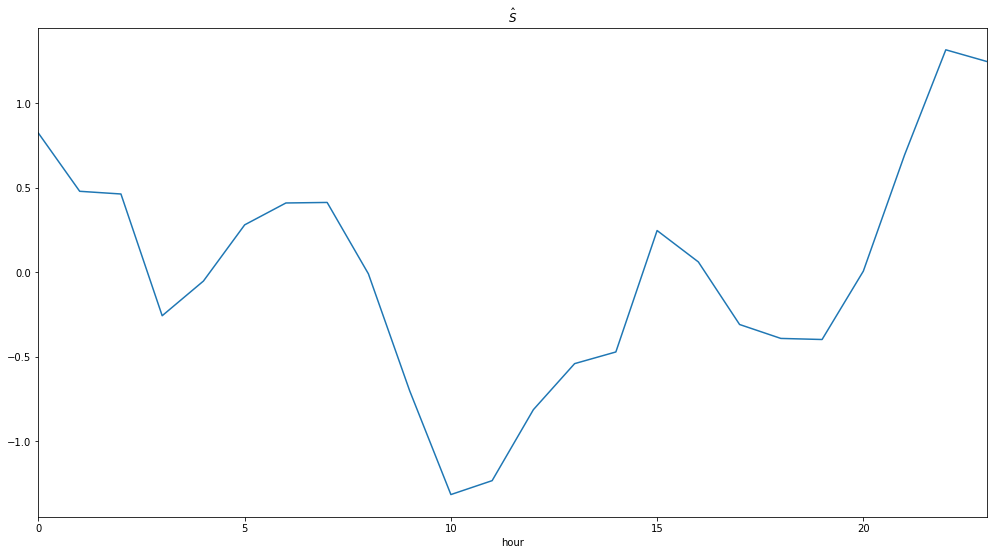

In [13]:
fig = plt.figure(figsize=(17, 9))
S['S'].plot(figure=fig)
plt.title(r"$\hat{S}$")
plt.show()

#### Interpretation:
Looks like we have the least amount of particulate matter at 10am and the most around midnight.
I wonder if the peaks from 6am to 7am and 3pm to 4pm have to do with Provo's driving habits.

### e
Remove the hourly seasonal component from the de-trended data to get $\hat{R}_t = y_t - \hat{S}_t$ (remember that $\hat{S}_{t+24}$ should equal  $\hat{S}_t$ for all $t$).
Plot the result.

In [14]:
#Join on the hour column to make S work out.
ydf = ydf.join(S, on='hour')
ydf['R'] = ydf.y - ydf.S

In [15]:
ydf.head(5)

y  hour         S         R
2015-01-01 12:00:00 -5.70    12 -0.812714 -4.887286
2015-01-01 13:00:00 -6.70    13 -0.540313 -6.159687
2015-01-01 14:00:00 -9.35    14 -0.471286 -8.878714
2015-01-01 15:00:00 -6.40    15  0.247034 -6.647034
2015-01-01 16:00:00 -3.10    16  0.061441 -3.161441

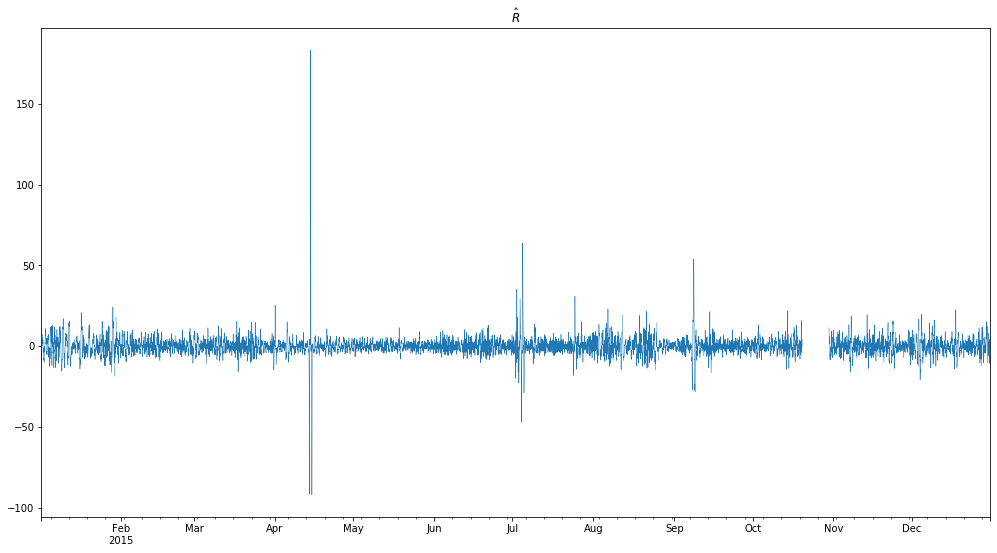

In [16]:
ydf.R.plot(figure=plt.figure(figsize=(17, 9)), linewidth=.5)
plt.title(r"$\hat{R}$")
plt.show()

### f
If the resulting time series is stationary, then the autocorrelation should be constant for each lag $k$.
Compute the sample mean and autocovariance $\gamma_k$ for each $k \in \{0, 1, \ldots, 50\}$ (treat each time $t$ and its corresponding $x_{t-k}$ as one sample pair). Use these to compute the autocorrelation for each $k$.  Plot the autocorrelation as a function of $k$.

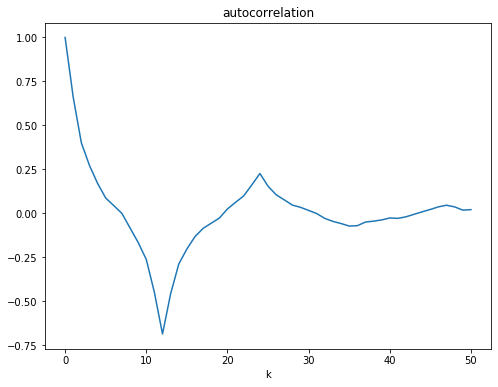

In [17]:
R = ydf.R

def get_mu_and_gamma(x):
    sample_mean = x.mean()
    gamma = np.empty((51, 2, 2))
    for k in range(51):
        t = x.index
        xtmk = x.copy(deep=True)
        xtmk.index += pd.to_timedelta(k, unit='hours')
        df = pd.concat((x, xtmk), axis=1)
        gamma[k] = df.cov()
    autocorrelation = gamma[:,0,1]/(np.sqrt(gamma[:,0,0]*gamma[:,1,1]))
    return sample_mean, gamma, autocorrelation

mu, gamma, autocorrelation = get_mu_and_gamma(R)

plt.figure(figsize=(8, 6))
plt.plot(autocorrelation)
plt.xlabel('k')
plt.title("autocorrelation")
plt.show()

### g
For each $j \in \{1, 2, 3\}$ compute the $j$th difference $\Delta^j\hat{R}_t$ time series and compute and plot the autocorrelation as a function of $k$ (as in part (ii)f) for each of these three time series.

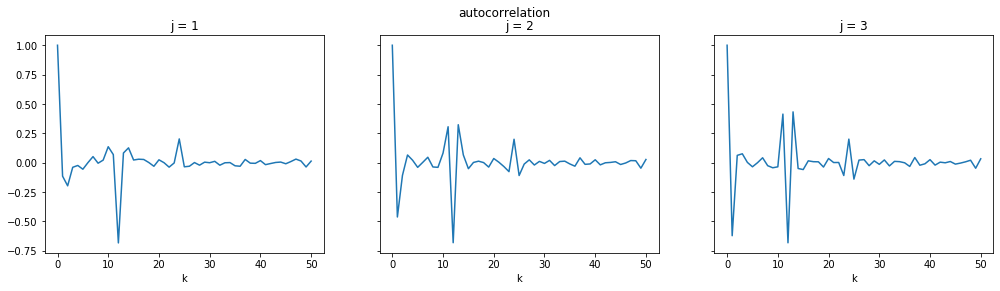

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 4), sharey=True)
axes = axes.ravel()
x = R.copy()
for j, ax in enumerate(axes):
    x = x.diff()
    mu, gamma, autocorrelation = get_mu_and_gamma(x)
    
    ax.plot(autocorrelation)
    ax.set_xlabel('k')
    ax.set_title("j = {}".format(j+1))
    
plt.suptitle("autocorrelation")
plt.show()